<a href="https://colab.research.google.com/github/mahyaalizadeh1995/Neural_style_transfer/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  %tensorflow_version 2.x
except:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from keras import backend as k

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from numpy.ma.core import minimum_fill_value
def tensor_to_image(tensor):
  ''' converts a tensor to an image '''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor)


def load_img(path_to_img):
  ''' loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1],tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale,tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis,:]
  image = tf.image.convert_image_dtype(image,tf.uint8)

  return image

def load_images(content_path, style_path):
  ''' loads the content and style images as tensors '''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image

def imshow(image, title=None):
  ''' displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def show_images_with_objects(images, titles=[]):
  ''' displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20,12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,len(images),idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)


def clip_image_values(image, min_value=0.0, max_value=255.0):
  ''' clips the image pixel values by the given min and max '''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)

def preprocessing_image(image):
  ''' preprocessing a given image to use with Inception model'''
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0

  return image



/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fC6I25RLG-0BEUnR3TwV240NqHqe0T-m
To: /content/content_image.jpg
100% 278k/278k [00:00<00:00, 92.7MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ltmiZVKuSUm5fK3lPyGJa4az8FCLDI9r
To: /content/sytle_image.webp
100% 147k/147k [00:00<00:00, 97.7MB/s]


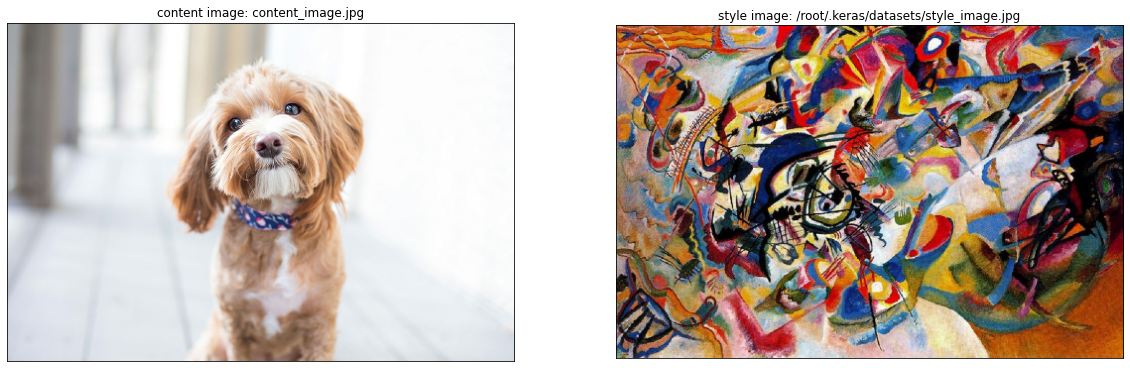

In [ ]:
! gdown --id 1fC6I25RLG-0BEUnR3TwV240NqHqe0T-m
! gdown --id 1ltmiZVKuSUm5fK3lPyGJa4az8FCLDI9r
content_path = '/content/content_image.jpg'
content_title = 'content_image.jpg'
style_path = tf.keras.utils.get_file('style_image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')


# display the content and style image
content_image, style_image = load_images(content_path,style_path)
show_images_with_objects([content_image,style_image],
                         titles=[f'content image: {content_title}',
                                f'style image: {style_path}'])

In [ ]:
# clear session to make layer naming consistent when re-running this cell
k.clear_session()

# download the inception model and inspect the layers
tmp_inception = tf.keras.applications.InceptionV3()
tmp_inception.summary()

# delete temporary model
del tmp_inception

96112376/96112376 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
#for extracting content features
content_layers = ['conv2d_87']
#for extracting style features
style_layers = ['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4']

#combine two types of layers
content_and_style_layers = content_layers + style_layers

# count the number of content layers and style layers
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [ ]:
def inception_model(layer_names):
  inception = tf.keras.applications.inception_v3.InceptionV3(include_top=False,weights="imagenet")
  inception.trainable = False

  output_layers = [inception.get_layer(name).output for name in layer_names]

  model = tf.keras.Model(inputs=inception.input, outputs=output_layers)

  return model

In [ ]:
k.clear_session()

inception = inception_model(content_and_style_layers)

In [ ]:
# calculate content and style loss

# style loss
def get_style_loss(features, targets):
  style_loss = tf.reduce_mean(tf.square(features - targets))

  return style_loss


# content loss
def get_content_loss(features, targets):
  content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))

  return content_loss

In [ ]:
def gram_matrix(input_tensor):
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

  input_shape = tf.shape(input_tensor)
  height = input_shape[1]
  width = input_shape[2]

  num_locations = tf.cast(height * width , tf.float32)

  scaled_gram = gram / num_locations

  return scaled_gram

In [ ]:
tmp_layer_list = [layer.output for layer in inception.layers]
tmp_layer_list

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'activation')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'activation_1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'batch_normalization_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'activation_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32

In [ ]:
def get_style_image_features(image):
  preprocessed_style_image = preprocessing_image(image)

  outputs = inception(preprocessed_style_image)

  style_outputs = outputs[:NUM_STYLE_LAYERS]

  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]

  return gram_style_features


In [ ]:
def get_content_image_features(image):
  preprocessed_content_image = preprocessing_image(image)

  outputs = inception(preprocessed_content_image)

  content_outputs = outputs[NUM_STYLE_LAYERS:]

  return content_outputs

In [ ]:
def get_style_content_loss(style_targets, style_outputs, content_targets,
                           content_outputs, style_weight, content_weight):
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                          for style_output, style_target in zip(style_outputs,style_targets)])

  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                          for content_output, content_target in zip(content_outputs,content_targets)])

  style_loss = style_weight * style_loss / NUM_STYLE_LAYERS
  content_loss = content_weight * content_loss / NUM_CONTENT_LAYERS

  total_loss = style_loss + content_loss

  return total_loss

In [ ]:
 def calculate_gradients(image, style_targets, content_targets,
                        style_weight, content_weight):
  with tf.GradientTape() as tape:

    # get the style image features
    style_features = get_style_image_features(image)

    # get the content image features
    content_features = get_content_image_features(image)

    # get the style and content loss
    loss = get_style_content_loss(style_targets, style_features, content_targets,
                                  content_features, style_weight, content_weight)

  # calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss, image)

  ### END CODE HERE ###

  return gradients

In [ ]:
def update_image_with_style(image, style_targets, content_targets, style_weight,
                            content_weight, optimizer):
  """
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    optimizer: optimizer for updating the input image
  """

  ### START CODE HERE ###
  # Calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, style_targets, content_targets,
                                  style_weight, content_weight)

  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)])

  ### END CODE HERE ###
  # Clip the image using the given clip_image_values() function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

In [ ]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4,
                       optimizer='adam', epochs=1, steps_per_epoch=1):
  """ Performs neural style transfer.
  Args:
    style_image: image to get style features from
    content_image: image to stylize
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    optimizer: optimizer for updating the input image
    epochs: number of epochs
    steps_per_epoch = steps per epoch

  Returns:
    generated_image: generated image at final epoch
    images: collection of generated images per epoch
  """

  images = []
  step = 0

  # get the style image features
  style_targets = get_style_image_features(style_image)

  # get the content image features
  content_targets = get_content_image_features(content_image)

  # initialize the generated image for updates
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image)

  # collect the image updates starting from the content image
  images.append(content_image)

  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1

      ### START CODE HERE ###
      # Update the image with the style using the function that you defined
      update_image_with_style(generated_image, style_targets, content_targets,
                              style_weight, content_weight, optimizer)

      ### END CODE HERE

      print(".", end='')
      if (m + 1) % 10 == 0:
        images.append(generated_image)

    # display the current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # append to the image collection for visualization later
    images.append(generated_image)
    print("Train step: {}".format(step))

  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

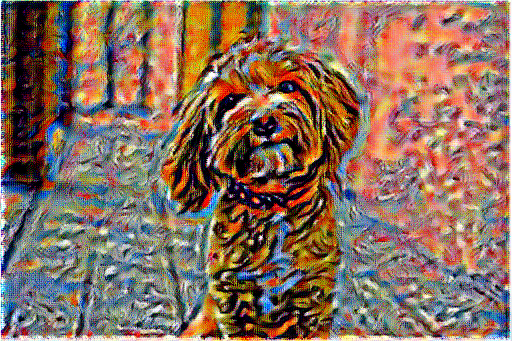

Train step: 1000


In [ ]:
style_weight =  1
content_weight = 1e-32

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image,
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)